# Process the data
This notebook shows a simple example of extracting data at a point on the downloaded xarray from the `load_data.ipynb` file. At the end of that file, I ran `%store ds` where `ds` is the xarray of SST values.

This compares 2 ways of getting SST from my data points (track). The first is very slow. The second is much faster, so scroll to the bottom.

In [6]:
# This is stored from load_data.ipynb file so run that first
%store -r ds

# Get SST at a particular lat/lon value
I have my lat/lon data in a file `data/sample_point_pairs.csv`. These are points along the North and South America coasts. My lat/lon values are not on the same grid as the SST data, so I need to find the "pixel" where my lat/lon value lies. 

In [8]:
import pandas as pd
df = pd.read_csv('../data/sample_point_pairs.csv')

Here is a lat/lon pair.

In [9]:
ns = [df.iloc[0]["lat.ns"], df.iloc[0]["lon.ns"]]
ns

[54.8932363035493, -164.839138084371]

Here is the code to get SST (in Kelvin) at a particular lat/lon point.

In [10]:
ds.analysed_sst.sel(lat=ns[0], lon=ns[1], method="nearest").values[0]

278.32

# Get the SST for all lat/lon pairs

First I will define a function that gets SST at a lat/lon pair. Why am I using a data frame? Because I don't know Python and I am used to working in with data frames in R. But I realize this is not the way to do things here.

In [11]:
def getsst(lat, lon):
    sst = ds.analysed_sst.sel(lat=lat, lon=lon, method="nearest").values[0]
    return sst

Now I can apply this get all the SST values for the pairs in my `df` of lat/lon pairs. First the nearshore pairs.

In [12]:
df['sst.ns'] = df.apply(lambda row: getsst(row['lat.ns'], row['lon.ns']), axis=1)

Next the offshore pairs.

In [14]:
df['sst.os'] = df.apply(lambda row: getsst(row['lat.os'], row['lon.os']), axis=1)

Now the difference.

In [15]:
df['sst.diff'] = df.apply(lambda row: row['sst.os'] - row['sst.ns'], axis=1)

Now the upwelling index.

In [16]:
df['up.index'] = df.apply(lambda row: row['sst.diff']>2, axis=1)

Add a location index. Just the index.

In [17]:
df['loc'] = df.index

# Make a plot

In [18]:
# Not sure I need this for pandas plotting
%matplotlib inline

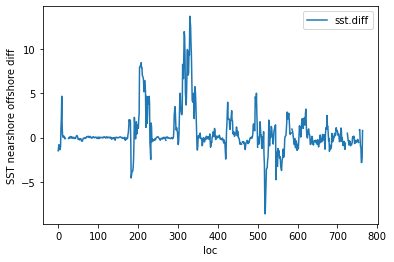

In [19]:
df.plot.line(x='loc',y='sst.diff', ylabel="SST nearshore offshore diff");

Ok that is not a useful plot, but I can see that it worked. Upwelling would be sst.diff > 2 approx.

# Make a function to do this
I need to compute the SST diff for each nc file. Because I work in R not Python, I am just doing the data crunching in Python and then I'll port that over to R to work on it. My data sets are not that huge. 800 coastal locations times 30 years times 365 days so about 1Gb of data.

In [20]:
def getsst(ras, lat, lon):
    sst = ras.analysed_sst.sel(lat=lat, lon=lon, method="nearest").values[0]
    return sst
def getdf(ras, pts):
    # takes a SST raster and the pandas pts data frame
    df_new = pts
    df_new['sst.ns'] = df_new.apply(lambda row: getsst(ras, row['lat.ns'], row['lon.ns']), axis=1)
    df_new['sst.os'] = df_new.apply(lambda row: getsst(ras, row['lat.os'], row['lon.os']), axis=1)
    df_new['sst.diff'] = df_new.apply(lambda row: row['sst.os'] - row['sst.ns'], axis=1)
    df_new['loc'] = df_new.index
    return df_new

Let's see how long this takes to run.

In [21]:
%timeit getdf(ds, df)

16.3 s ± 60 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Takes about 16 seconds to run one day. Hmm that will take 2 days to run 30 years worth of data, and I started with 0.25 grid data and just the nearshore/offshore difference so the super easy case. The MUR data is 0.01 grid and I'll be doing an area average not the SST at the point. Hmm... maybe there is a faster way to do this simple calculation.

In [22]:
16*30*365/(60*60)

48.666666666666664

# Alternate approach using indices
From https://github.com/ICESAT-2HackWeek/xarray_open_tutorial/blob/master/xarray_examples.ipynb

In [70]:
import xarray as xr
import numpy as np

In [44]:
ind_x = xr.DataArray(df["lon.ns"], dims=['i'])
ind_y = xr.DataArray(df["lat.ns"], dims=['i'])

In [79]:
test = ds.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest').values
test[0, 0:20]

array([278.32   , 278.00998, 277.69998, 278.00998, 278.03   , 277.83   ,
       277.29   , 274.81   , 273.84   , 271.77   , 272.74   , 272.18   ,
       271.94998, 271.85   , 271.66998, 271.61   , 271.77   , 271.69   ,
       271.6    ,       nan], dtype=float32)

Make a function to do this.

In [77]:
def getdf2(ras, pts):
    ind_x = xr.DataArray(df["lon.ns"], dims=['i'])
    ind_y = xr.DataArray(df["lat.ns"], dims=['i'])
    xr_new = ras.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest').values
    ind_x = xr.DataArray(df["lon.os"], dims=['i'])
    ind_y = xr.DataArray(df["lat.os"], dims=['i'])
    xr_new = np.vstack((xr_new, ras.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest').values))
    return xr_new

In [78]:
%timeit getdf2(ds, df)

105 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is much faster!